# Predict Future Sales

Second part of feauture enginering and ML modeling - testing advanced models and advanced features

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns; sns.set()
import random
from dateutil.relativedelta import relativedelta
import os

In [2]:
from my_functions import merge_basic, scaler, inversed_scale, consolidation_prediction, plot_prediction
from my_functions import preparing_to_predict, plot_metrics

In [3]:
from especial_functions import balance_items_test, get_full_lags, feature_silver, integration_new_features_map
from especial_functions import features_rows_train_silver, get_maps_from, balance_items_test
from especial_functions import augmentation_reduction

In [4]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [5]:
#from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans

In [6]:
import warnings
warnings.filterwarnings('ignore')

### Data

In [7]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Data modeling

In [8]:
def exploiting_words(data):
    items_vector = list(data.item_name.unique())
    items_vector = pd.DataFrame({'item_name': items_vector})
    items_vector['lenstr'] = items_vector.item_name.str.len() ## this can be a feature
    items_vector['NWords'] = items_vector.item_name.str.split().str.len()
    items_vector['ItemWord0'] = items_vector.item_name.str.split().str.get(0)
    items_vector['ItemWord_1'] = items_vector.item_name.str.split().str.get(-1)
    
    def my_tokengen(data, columnx):
        unique_words = list()
        for string in  list(data[columnx].values):
            for word in string.split():
                unique_words.append(word)
        unique_words = set(unique_words)
        unique_words = list(unique_words)
        unique_words.sort()
        number = [idx[0] +1 for idx in enumerate(unique_words)]
        map_word = {x:y for x,y in zip(unique_words, number)}

        data[columnx] = data[columnx].map(map_word)
        return data
    
    items_vector = my_tokengen(items_vector, 'ItemWord0')
    items_vector = my_tokengen(items_vector, 'ItemWord_1')
    items_vector = items_vector.merge(data[['item_name','item_id']], on = 'item_name', how = 'left').drop(columns = 'item_name')
    
    return {'item_name_explo':items_vector}

In [9]:
def cleaning_shop_categs(shops, categories):
    shops[['shop_comp1','shop_comp2']] = shops.shop_name.str.split(' "',expand=True,)
    shops['shop_comp1'] = shops.shop_comp1.replace({r'\([^)]*\)' : ''}, regex=True)
    shops['shop_comp1'] = shops['shop_comp1'].str.split(' ').str[0]

    shops['shop_comp2'] = shops.shop_comp2.replace({r'\([^)]*\)' : ''}, regex=True)
    shops['shop_comp2'] = shops.shop_comp2.replace({'"' :''}, regex=True)

    categories[['categ_comp1','categ_comp2']] = categories.item_category_name.str.split(" - ",expand=True,)
    categories['categ_comp1'] = categories.categ_comp1.replace({r'\([^)]*\)' : ''}, regex=True)
    categories['categ_comp2'] = categories.categ_comp2.replace({r'\([^)]*\)' : ''}, regex=True)
    
    return shops, categories

def indexing_shop_categs(data, column):
    my_map = dict()
    for index, value in enumerate(data[column].unique()):
        my_map[value] = index
    data[f'map_{column}'] = data[column].map(my_map)
    return data

<b> Treating the map item, category and shop

In [10]:
items_feature =  exploiting_words(data = items)

In [11]:
shops_feature, categories_feature = cleaning_shop_categs(shops, categories)
shops_feature = indexing_shop_categs(shops_feature, 'shop_comp1')
shops_feature = indexing_shop_categs(shops_feature, 'shop_comp2')
categories_feature = indexing_shop_categs(categories_feature, 'categ_comp1')
categories_feature = indexing_shop_categs(categories_feature, 'categ_comp2')

<b> Fast Cleaning

In [12]:
median = daily_train[(daily_train.shop_id == 32) & (daily_train.item_id == 2973) & (daily_train.date_block_num == 4) & (daily_train.item_price > 0)].item_price.median()
daily_train.loc[daily_train.item_price < 0, 'item_price'] = median

In [13]:
daily_train.loc[daily_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
daily_train.loc[daily_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
daily_train.loc[daily_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [14]:
### test preparation
test_data = test
test_data['date'] = pd.to_datetime(datetime.datetime(2015, 11, 1))
test_data['date_block_num'] = 35
test_data['item_price'] =  np.nan
test_data['item_cnt_day'] = np.nan
test_data = test_data[daily_train.columns]

In [15]:
test_data.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2015-11-01              35        5     5037         NaN           NaN
1 2015-11-01              35        5     5320         NaN           NaN
2 2015-11-01              35        5     5233         NaN           NaN
3 2015-11-01              35        5     5232         NaN           NaN
4 2015-11-01              35        5     5268         NaN           NaN

In [16]:
daily_train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

<b> preparing Train aggregation

In [17]:
def convert_bronze(data, train = False, test_order = 34):
    if train:
        data['date'] = pd.to_datetime(data['date'], format = '%d.%m.%Y')
        
    data['SaleDateMY'] = data['date'].dt.to_period('M').dt.to_timestamp()
    data['item_cnt_day'] = data['item_cnt_day'].clip(0,20)
    
    data = data.groupby(['SaleDateMY', 'date_block_num', 'shop_id', 'item_id'],
                                ).agg( Sale = ('item_cnt_day', 'sum'),
                                   item_price = ('item_price', 'mean'))
    data = data.reset_index().rename(columns = {'SaleDateMY':'Date'})
    
    data['min_date'] = data.groupby(['shop_id', 'item_id'])['Date'].transform('min')

    ### completing with 0 items with 0 in no dates
    
    map_aggg = data[['Date','item_id','shop_id','min_date','Sale']]\
        .pivot_table(index = ['item_id','shop_id','min_date'], columns = ['Date'], values = 'Sale', aggfunc = 'count').reset_index()
    map_aggg = map_aggg.melt(id_vars=['item_id','shop_id','min_date'], value_vars = map_aggg.columns[2:],  var_name='Date', value_name='Nothing')
    map_aggg = map_aggg[map_aggg.Date >= map_aggg.min_date]
    map_aggg = map_aggg[['item_id','shop_id','Date']]
    
    group_data = map_aggg.merge(data, on = ['item_id','shop_id','Date'], how = 'left').fillna(0)
    group_data['Sale'] = group_data['Sale'].clip(0,20)
    
    del map_aggg
    
    if train:
        ### get a map of the dates
        date_list =[group_data.Date.min()]
        date = group_data.Date.min()
        max_date = group_data.Date.max()
        while date <= max_date:
            date = date_list[-1] + relativedelta(months=1)
            date_list.append(date)
        order_list = range(1,len(date_list)+1)
        date_map = pd.DataFrame({'Date':date_list, 'Order':order_list})
        group_data = group_data.merge(date_map, on = 'Date', how = 'left')
    group_data = group_data.drop(columns = ['date_block_num', 'min_date'])
    return group_data

In [18]:
def merge_basic(train_data, items, items_feature ,categories, shops):
    train_merge = train_data.merge(items, on = 'item_id', how = 'left')
    train_merge = train_merge.merge(items_feature, on = 'item_id', how = 'left')
    train_merge = train_merge.merge(categories, on = 'item_category_id', how = 'left')
    train_merge = train_merge.merge(shops, on = 'shop_id', how = 'left')

    return train_merge

In [19]:
daily_train.shape

(2935849, 6)

In [20]:
train_bronze = convert_bronze(data = daily_train, train = True)

In [21]:
train_bronze.shape

(9784152, 6)

In [22]:
train_merge = merge_basic(train_data = train_bronze, items = items, items_feature = items_feature['item_name_explo'],
                            categories = categories_feature, shops = shops_feature)

In [23]:
train_merge.shape

(9784152, 22)

<b> Splitting strategy:

* time series expanding window of one period, Take 7 months
* over the first fold, make the functions and features for modeling and prediction (avoid leakage)
* lags and seasons are features
* use rmse as metric
* consider the outputs of the EDA
* goal, predict november or yyyy-11-01

#### The validation data

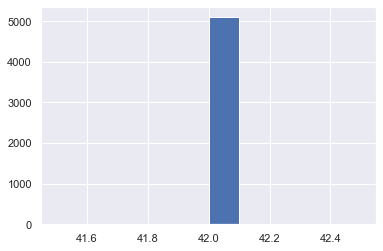

In [24]:
test_data.groupby(['item_id']).agg(lit = ('shop_id','nunique')).reset_index().lit.hist()

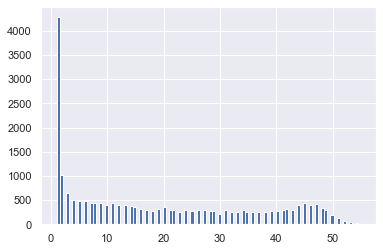

In [25]:
daily_train.groupby(['item_id']).agg(lit = ('shop_id','nunique')).reset_index().lit.hist(bins = 100)

In [26]:
#len(daily_train.item_id.unique()),len(test_data.item_id.unique()), len(test_data.merge(daily_train, on = ['item_id'], how ='inner').item_id.unique())

In [27]:
#len(daily_train.groupby(['shop_id','item_id']).agg(lit = ('item_cnt_day','max')).reset_index()) ,len(test_data),  len(test_data.merge(daily_train, on = ['item_id','shop_id'], how ='inner').item_id.unique())

<b> validation must be some data with historique and some very new data

In [28]:
def supagg(data):
    data['lit'] = data.groupby(['item_id'])['shop_id'].transform('nunique')
    agge = data.groupby(['item_id','shop_id']).agg(lit = ('lit','max')).reset_index()
    return agge

In [29]:
agg_daily_train = supagg(daily_train)

In [30]:
def  reduce_sample(data, frac, single = False ):
    if single:
        data = data.groupby(['item_id','shop_id']).agg(lit = ('lit','max')).reset_index().sample(frac = frac, random_state = 123)
    else:
        data = data.sample(frac = frac, random_state = 123)
        data = data[['item_id','shop_id','lit']]
    return data

In [31]:
vector_drop_1 = reduce_sample(data = agg_daily_train[agg_daily_train.lit > 10], frac = 0.60)
vector_drop_2 = reduce_sample(data = agg_daily_train[agg_daily_train.lit <= 1], frac = 0.60, single = True)

In [32]:
itemshop_to_drop_1 = list(vector_drop_1.assign(shopitem = vector_drop_1.shop_id.astype('str') + '_' + vector_drop_1.item_id.astype('str'))\
                        .shopitem.unique())
itemshop_to_drop_2 = list(vector_drop_2.assign(shopitem = vector_drop_2.shop_id.astype('str') + '_' + vector_drop_2.item_id.astype('str'))\
                        .shopitem.unique())

items_to_drop_all = itemshop_to_drop_1 + itemshop_to_drop_2

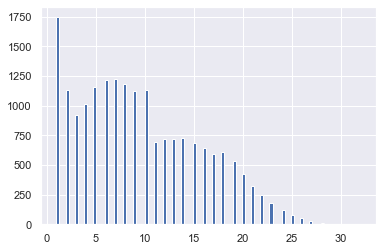

In [33]:
daily_train = daily_train.assign(shopitem = daily_train.shop_id.astype('str') + '_' + daily_train.item_id.astype('str'))

daily_train[ ~daily_train.shopitem.isin(items_to_drop_all) ]\
    .groupby(['item_id']).agg(lit = ('shop_id','nunique')).reset_index().lit.hist(bins = 100)

In [34]:
train_bronze.Date.max()

Timestamp('2015-10-01 00:00:00')

In [35]:
test_dates = [datetime.datetime(2014, 11, 1), datetime.datetime(2015, 4, 1), datetime.datetime(2015, 5, 1), datetime.datetime(2015, 6, 1), datetime.datetime(2015, 7, 1), datetime.datetime(2015, 8, 1),
datetime.datetime(2015, 9, 1), datetime.datetime(2015, 10, 1),]

#### hold-out Train

 almost 95% of the items available

In [36]:
date_val = datetime.datetime(2014, 10, 1)

In [37]:
train_merge = train_merge.assign(shopitem = train_merge.shop_id.astype('str') + '_' + train_merge.item_id.astype('str'))

In [38]:
def get_val_window(data, date, items_to_drop_all):
    val_window_1 = data[data.Date == date ]
    already_found = val_window_1.shopitem.unique()
    
    val_window_2 = data[ (data.Date != date) & (data.shopitem.isin(items_to_drop_all)) ]
    val_window_2['Order'] = val_window_2.groupby(['shop_id','item_id']).cumcount() + 1
    val_window_2 = val_window_2[val_window_2.Order == 1]
    val_window_2['Date'] = date
    val_window_2 = val_window_2[~val_window_2.shopitem.isin(already_found)]
    val_window_2['Sale'] = 0
    print(len(val_window_1),len(val_window_2))
    val_window = pd.concat([val_window_1,val_window_2])
    return val_window

In [39]:
train_full = train_merge[(train_merge.Date < date_val) & (~train_merge.shopitem.isin(items_to_drop_all))]  # itemshop_to_drop_2
val_window = get_val_window(data = train_merge, date = date_val, items_to_drop_all = items_to_drop_all)

339005 44222


In [40]:
train_full.columns

Index(['item_id', 'shop_id', 'Date', 'Sale', 'item_price', 'Order',
       'item_name', 'item_category_id', 'lenstr', 'NWords', 'ItemWord0',
       'ItemWord_1', 'item_category_name', 'categ_comp1', 'categ_comp2',
       'map_categ_comp1', 'map_categ_comp2', 'shop_name', 'shop_comp1',
       'shop_comp2', 'map_shop_comp1', 'map_shop_comp2', 'shopitem'],
      dtype='object')

In [41]:
train_full.Date.max(), train_full.Date.min()

(Timestamp('2014-09-01 00:00:00'), Timestamp('2013-01-01 00:00:00'))

In [42]:
train_full.shape, val_window.shape

((2098106, 23), (383227, 23))

### Exploration of the features

In [43]:
var1 = 'item_id'
var2 = 'shop_id'

dfplot = train_full.assign(month = train_full.Date.dt.month).groupby([var1, var2, 'month','item_category_id',
                             'map_categ_comp1','map_categ_comp2',
                             'ItemWord0','ItemWord_1',
                             'map_shop_comp1', 'map_shop_comp2']).agg(counts = ('Sale', 'count')).reset_index()

In [44]:
dfplot.sort_values('counts', ascending = False)

item_id  shop_id  month  item_category_id  map_categ_comp1  \
743109     11475       42      4                40               11   
558954      8855       52      9                57               13   
558963      8855       57      6                57               13   
558964      8855       57      7                57               13   
558965      8855       57      8                57               13   
...          ...      ...    ...               ...              ...   
625760      9920       31      4                40               11   
625761      9920       31      5                40               11   
625762      9920       31      6                40               11   
625763      9920       31      7                40               11   
1486217    22168       43     12                62               14   

         map_categ_comp2  ItemWord0  ItemWord_1  map_shop_comp1  \
743109                22       2529        2431              20   
558954                38       1670         400              26   
558963                38       1670         400              30   
558964                38       1670         400              30   
558965                38       1670         400              30   
...                  ...        ...         ...             ...   
625760                22       2024         436              14   
625761                22       2024         436              14   
625762                22       2024         436              14   
625763                22       2024         436              14   
1486217               43       5252        1697              20   

         map_shop_comp2  counts  
743109               32       2  
558954               42       2  
558963                0       2  
558964                0       2  
558965                0       2  
...                 ...     ...  
625760               24       1  
625761               24       1  
625762               24       1  
625763               24       1  
1486217              33       1  

[1486218 rows x 11 columns]

In [45]:
dfplot2 = dfplot.groupby(['month','map_categ_comp1', 'map_shop_comp1']).agg(mins = ('counts', 'min'), maxs = ('counts', 'max'), means = ('counts','mean')).reset_index()
dfplot2['index'] = 1

In [46]:
dfplot2['index'] = dfplot2.groupby(['month'])['index'].cumsum()

In [47]:
dfplot2.sort_values('means')

month  map_categ_comp1  map_shop_comp1  mins  maxs  means  index
2202      7                2              29     1     1    1.0     36
3509     10               11               2     1     1    1.0    164
3510     10               11               3     1     1    1.0    165
3511     10               11               4     1     1    1.0    166
3512     10               11               5     1     1    1.0    167
...     ...              ...             ...   ...   ...    ...    ...
1047      3               17              30     2     2    2.0    336
1050      3               18               5     2     2    2.0    339
3289      9               16               2     2     2    2.0    349
3291      9               16               9     2     2    2.0    351
2526      7               18               3     2     2    2.0    360

[4405 rows x 7 columns]

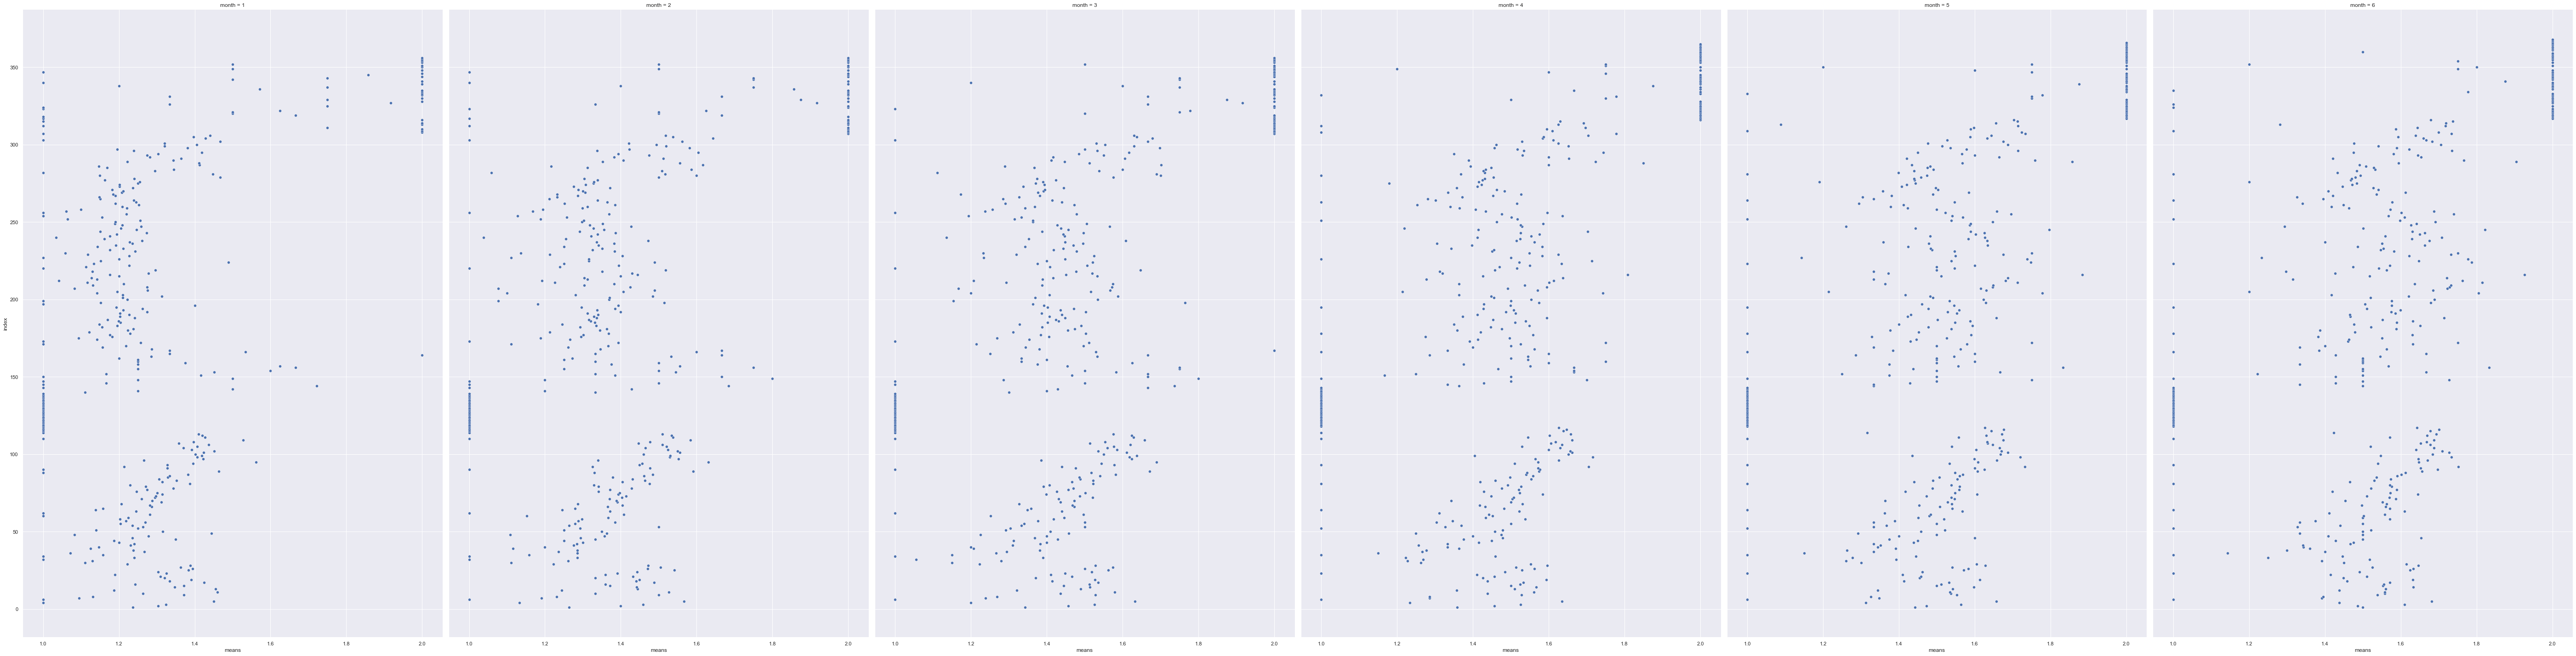

In [48]:
#fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(7,10), sharex=True)
g = sns.FacetGrid(dfplot2[dfplot2.month.isin([1,2,3,4,5,6])], col="month", height=20, aspect=.65 )
g.map(sns.scatterplot, 'means', 'index')

In [49]:
gato = [5,10]
tmp = train_full[(train_full.Sale >= gato[0]) & (train_full.Sale <= gato[1])].groupby(['Date','shop_id']).agg(counts = ('Sale','count')).reset_index()

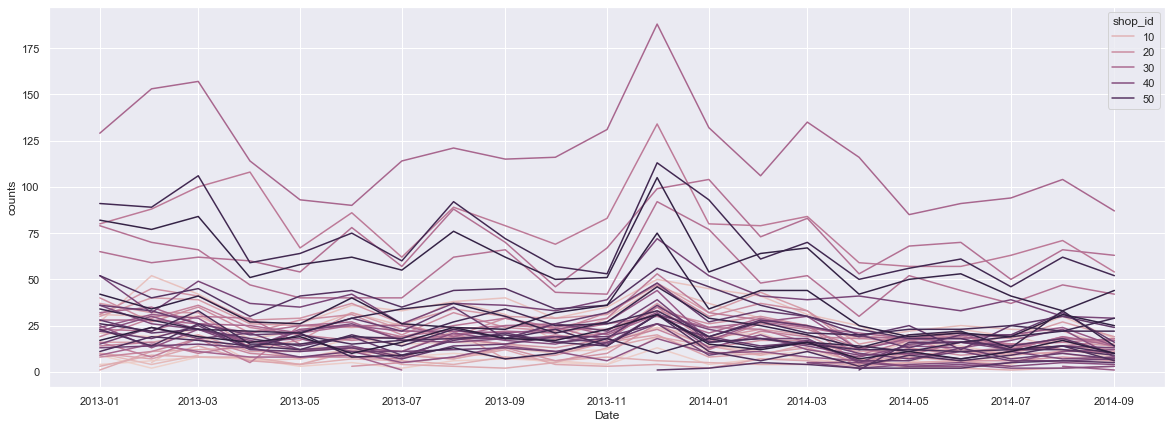

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7), sharex=True)
sns.lineplot(ax = axs , data=tmp, x='Date', y= 'counts', hue="shop_id")

In [51]:
gato = [1,5]
tmp = train_full[(train_full.Sale >= gato[0]) & (train_full.Sale <= gato[1])].groupby(['Date','ItemWord0']).agg(counts = ('Sale','count')).reset_index()

In [52]:
tmp

Date  ItemWord0  counts
0     2013-01-01         19       1
1     2013-01-01         27       4
2     2013-01-01         29      20
3     2013-01-01         30      13
4     2013-01-01         31      28
...          ...        ...     ...
49324 2014-09-01       5238       3
49325 2014-09-01       5239      13
49326 2014-09-01       5240       1
49327 2014-09-01       5242       1
49328 2014-09-01       5251       6

[49329 rows x 3 columns]

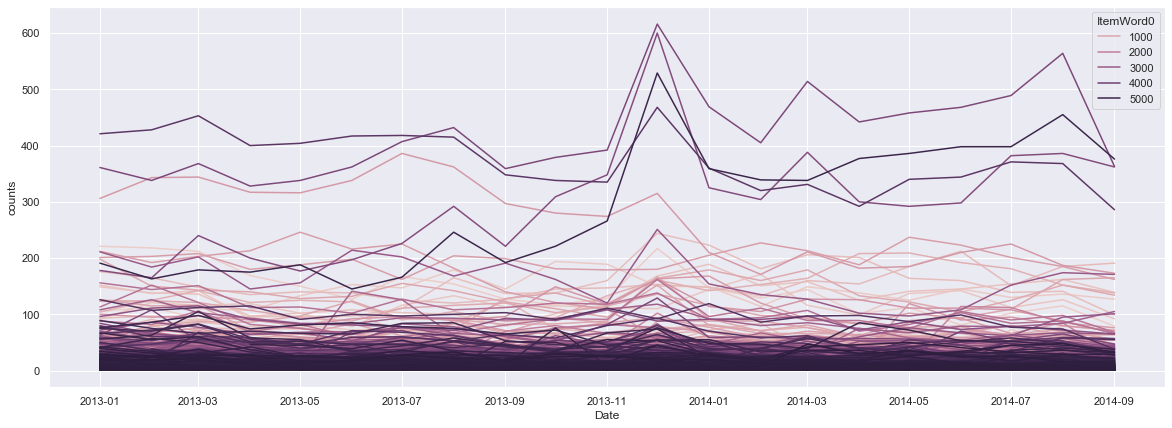

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7), sharex=True)
sns.lineplot(ax = axs , data=tmp, x='Date', y= 'counts', hue="ItemWord0")

In [54]:
train_full.columns

Index(['item_id', 'shop_id', 'Date', 'Sale', 'item_price', 'Order',
       'item_name', 'item_category_id', 'lenstr', 'NWords', 'ItemWord0',
       'ItemWord_1', 'item_category_name', 'categ_comp1', 'categ_comp2',
       'map_categ_comp1', 'map_categ_comp2', 'shop_name', 'shop_comp1',
       'shop_comp2', 'map_shop_comp1', 'map_shop_comp2', 'shopitem'],
      dtype='object')

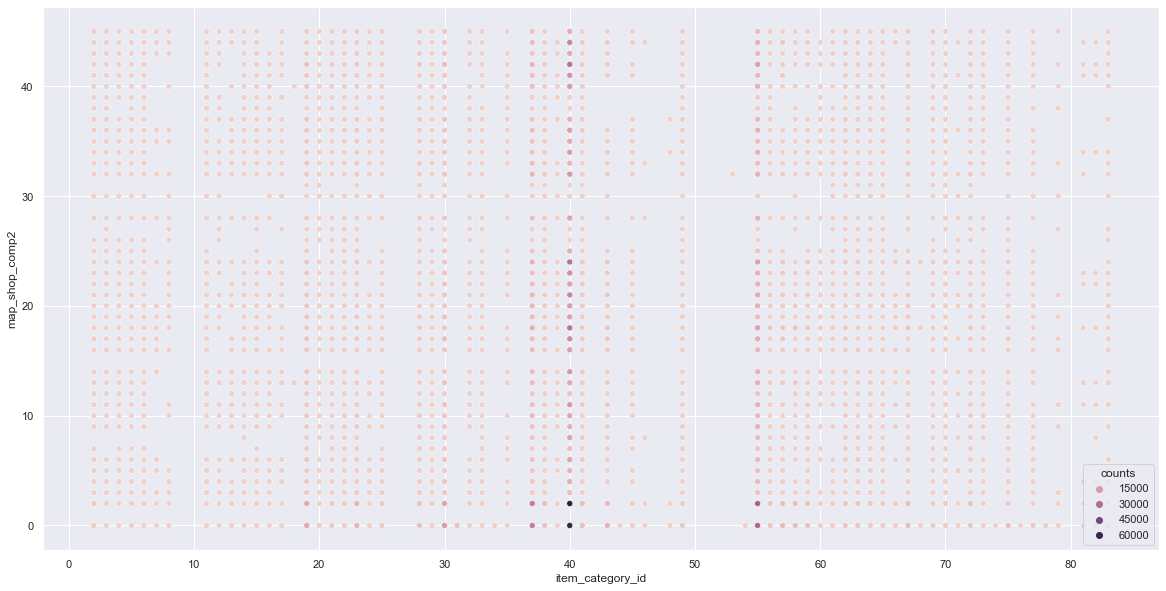

In [55]:
var1 = 'item_category_id'
var2 = 'map_shop_comp2'

dfplot = train_full.groupby([var1, var2]).agg(counts = ('Sale', 'count')).reset_index()

fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,10), sharex=True)
sns.scatterplot(ax = axs , data=dfplot, x=var1, y= var2, hue="counts")

#### vart1 = 'shop_id'
dfplot2 = dfplot.groupby(vart1).agg(mins = ('counts', 'min'), maxs = ('counts', 'max')).reset_index()

fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(7,10), sharex=True)
sns.scatterplot(ax = axs , data=dfplot2, x='mins', y= vart1)
sns.scatterplot(ax = axs , data=dfplot2, x='maxs', y= vart1)

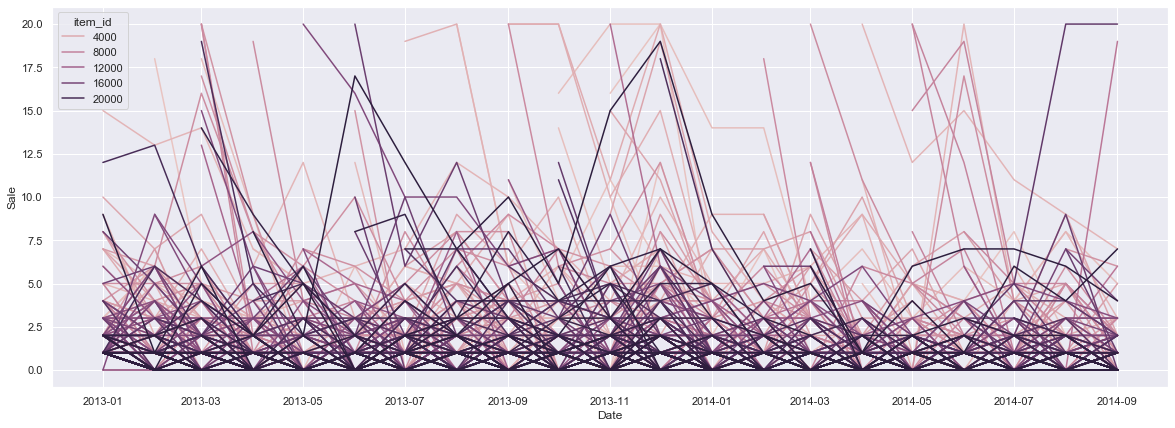

In [56]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7), sharex=True)
sns.lineplot(ax = axs , data=train_full[train_full.shop_id == 59], x='Date', y= 'Sale', hue="item_id")

In [57]:
train_full.item_id.unique()

array([   19,    27,    28, ..., 21681, 21877, 21878], dtype=int64)

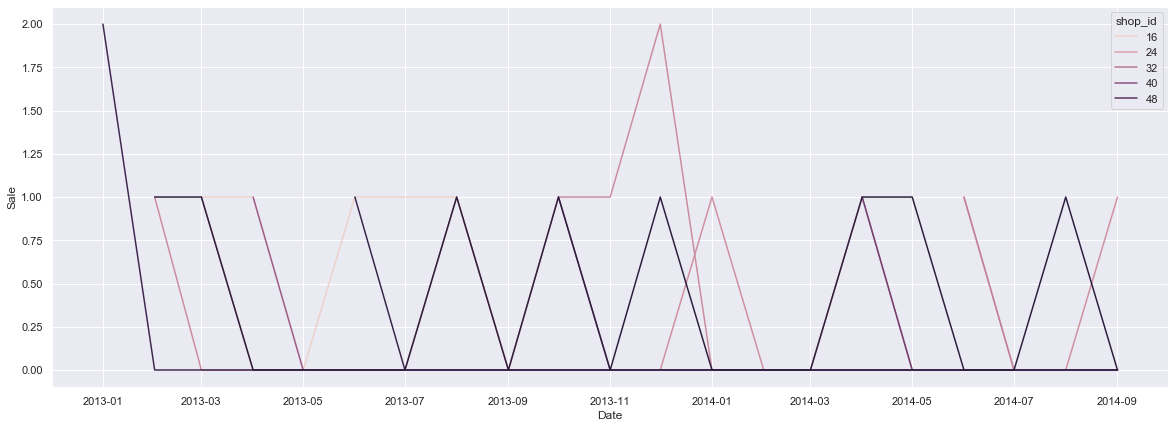

In [58]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7), sharex=True)
sns.lineplot(ax = axs , data=train_full[train_full.item_id == 197], x='Date', y= 'Sale', hue="shop_id")

In [59]:
test_bronze = convert_bronze(data = test_data, train = False)
test_merged = merge_basic(train_data = test_bronze, items = items, items_feature = items_feature['item_name_explo'],
                            categories = categories_feature, shops = shops_feature)

In [60]:
var = 'map_categ_comp1'
comp1 = train_full.groupby(['shop_id']).agg(countVarsTest = (var,'nunique')).reset_index()

test_categos = train_full[var].unique()
comp2 = test_merged[test_merged[var].isin(test_categos)].groupby(['shop_id']).agg(countVarsTrain = (var,'nunique')).reset_index()

causa = comp1.merge(comp2, on = 'shop_id', how = 'left')
causa['percCov'] = (causa['countVarsTrain'] / causa['countVarsTest'] )*100

causa.head()

shop_id  countVarsTest  countVarsTrain    percCov
0        2             14            12.0  85.714286
1        3             13            12.0  92.307692
2        4             14            12.0  85.714286
3        5             13            12.0  92.307692
4        6             15            12.0  80.000000

### rolling mean ceros ADDMEEEEE

In [61]:
tmp = train_full[['item_id','shop_id','Sale','Date']].assign(cero = np.where(train_full.Sale == 0,1,0))

tmp = tmp.groupby(['item_id','Date']).agg(cero = ('cero','sum')).reset_index()
roll_calc = tmp.groupby(['item_id']).rolling('90D', on="Date")["cero"].mean()
tmp = tmp.set_index(['item_id','Date'])
tmp["roll_sum_ceros"] = roll_calc
tmp = tmp.reset_index()

In [62]:
tmp[(tmp.item_id == 197) ]

item_id       Date  cero  roll_sum_ceros
1625      197 2013-01-01     0        0.000000
1626      197 2013-02-01     1        0.500000
1627      197 2013-03-01     2        1.000000
1628      197 2013-04-01     4        2.333333
1629      197 2013-05-01     6        3.250000
1630      197 2013-06-01     5        5.000000
1631      197 2013-07-01     6        5.666667
1632      197 2013-08-01     4        5.000000
1633      197 2013-09-01     7        5.666667
1634      197 2013-10-01     5        5.333333
1635      197 2013-11-01     7        6.333333
1636      197 2013-12-01     6        6.000000
1637      197 2014-01-01     7        6.666667
1638      197 2014-02-01     8        7.000000
1639      197 2014-03-01     8        7.666667
1640      197 2014-04-01     6        7.333333
1641      197 2014-05-01     8        7.500000
1642      197 2014-06-01     9        7.666667
1643      197 2014-07-01    11        9.333333
1644      197 2014-08-01    10       10.000000
1645      197 2014-09-01    10       10.333333

In [63]:
train_full.columns

Index(['item_id', 'shop_id', 'Date', 'Sale', 'item_price', 'Order',
       'item_name', 'item_category_id', 'lenstr', 'NWords', 'ItemWord0',
       'ItemWord_1', 'item_category_name', 'categ_comp1', 'categ_comp2',
       'map_categ_comp1', 'map_categ_comp2', 'shop_name', 'shop_comp1',
       'shop_comp2', 'map_shop_comp1', 'map_shop_comp2', 'shopitem'],
      dtype='object')

### Exploreme further

In [64]:
tmp = train_full[['item_id','shop_id','Sale','Date','item_category_id','Order']]
tmp['ItemStart'] = tmp.groupby(['item_id']).Order.transform('min')
tmp['shopItemStart'] = tmp.groupby(['item_id','shop_id']).Order.transform('min')
tmp['shopItemLapse'] = tmp['shopItemStart'] - tmp['ItemStart'] 

In [65]:
def q75(x):
    return x.quantile(0.75)

In [66]:
tmp.groupby(['shop_id']).agg(Min = ('shopItemLapse','min'), Median = ('shopItemLapse','median'), Q75 = ('shopItemLapse', q75), Max = ('shopItemLapse','max')).reset_index().head()

shop_id  Min  Median  Q75  Max
0        2    0     1.0  3.0   20
1        3    0     1.0  3.0   20
2        4    0     1.0  2.0   20
3        5    0     2.0  5.0   20
4        6    0     1.0  2.0   20

In [67]:
tmp[(tmp.shop_id == 5) & (tmp.shopItemLapse == 2)]

item_id  shop_id  Sale       Date  item_category_id  Order  \
163015       971        5   1.0 2013-03-01                55      3   
163432      1003        5   2.0 2013-03-01                67      3   
163696      1015        5   1.0 2013-03-01                67      3   
164689      1143        5   1.0 2013-03-01                55      3   
165162      1247        5   1.0 2013-03-01                55      3   
...          ...      ...   ...        ...               ...    ...   
4788234    21719        5   0.0 2014-09-01                37     21   
4790273    21842        5   1.0 2014-09-01                40     21   
4793626    22029        5   0.0 2014-09-01                40     21   
4793730    22040        5   0.0 2014-09-01                40     21   
4795182    22130        5   0.0 2014-09-01                40     21   

         ItemStart  shopItemStart  shopItemLapse  
163015           1              3              2  
163432           1              3              2  
163696           1              3              2  
164689           1              3              2  
165162           1              3              2  
...            ...            ...            ...  
4788234         12             14              2  
4790273          4              6              2  
4793626          3              5              2  
4793730          1              3              2  
4795182          1              3              2  

[3819 rows x 9 columns]

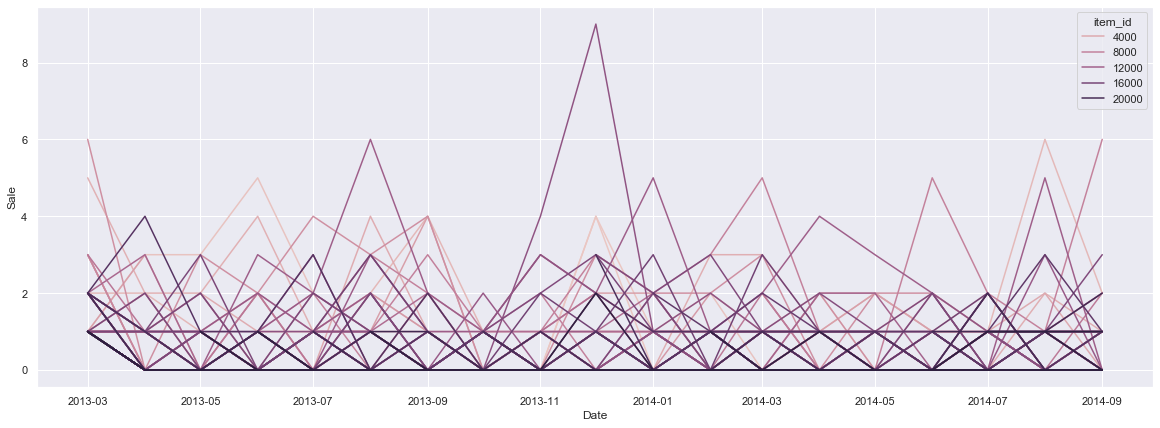

In [68]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7), sharex=True)
sns.lineplot(ax = axs , data=tmp[(tmp.shop_id == 5) & (tmp.shopItemLapse == 2)], x='Date', y= 'Sale', hue="item_id")

In [69]:
tmp[(tmp.shop_id == 5) & (tmp.shopItemLapse == 2)]

item_id  shop_id  Sale       Date  item_category_id  Order  \
163015       971        5   1.0 2013-03-01                55      3   
163432      1003        5   2.0 2013-03-01                67      3   
163696      1015        5   1.0 2013-03-01                67      3   
164689      1143        5   1.0 2013-03-01                55      3   
165162      1247        5   1.0 2013-03-01                55      3   
...          ...      ...   ...        ...               ...    ...   
4788234    21719        5   0.0 2014-09-01                37     21   
4790273    21842        5   1.0 2014-09-01                40     21   
4793626    22029        5   0.0 2014-09-01                40     21   
4793730    22040        5   0.0 2014-09-01                40     21   
4795182    22130        5   0.0 2014-09-01                40     21   

         ItemStart  shopItemStart  shopItemLapse  
163015           1              3              2  
163432           1              3              2  
163696           1              3              2  
164689           1              3              2  
165162           1              3              2  
...            ...            ...            ...  
4788234         12             14              2  
4790273          4              6              2  
4793626          3              5              2  
4793730          1              3              2  
4795182          1              3              2  

[3819 rows x 9 columns]

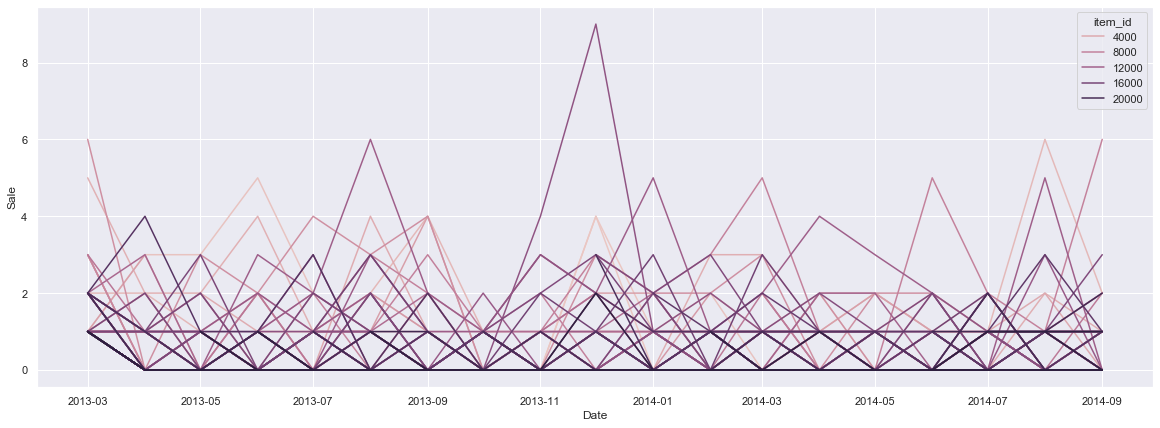

In [70]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7), sharex=True)
sns.lineplot(ax = axs , data=tmp[(tmp.shop_id == 5) & (tmp.shopItemLapse == 2)], x='Date', y= 'Sale', hue="item_id")

In [71]:
tmp = train_full[['item_id','shop_id','item_category_id','Order','Date','Sale']]
tmp['SaleL1'] = tmp.sort_values('Date').groupby(['item_id','shop_id'])['Sale'].shift(1)
tmp['SaleDiff'] = tmp['Sale'] - tmp['SaleL1']

In [72]:
tmp[(tmp.item_id == 22168) & (tmp.shop_id == 42)].head(10)

item_id  shop_id  item_category_id  Order       Date  Sale  SaleL1  \
160454     22168       42                62      2 2013-02-01   1.0     NaN   
287157     22168       42                62      3 2013-03-01   0.0     1.0   
433575     22168       42                62      4 2013-04-01   0.0     0.0   
596291     22168       42                62      5 2013-05-01   0.0     0.0   
775156     22168       42                62      6 2013-06-01   0.0     0.0   
967799     22168       42                62      7 2013-07-01   0.0     0.0   
1173253    22168       42                62      8 2013-08-01   0.0     0.0   
1389789    22168       42                62      9 2013-09-01   0.0     0.0   
1618364    22168       42                62     10 2013-10-01   0.0     0.0   
1858740    22168       42                62     11 2013-11-01   0.0     0.0   

         SaleDiff  
160454        NaN  
287157       -1.0  
433575        0.0  
596291        0.0  
775156        0.0  
967799        0.0  
1173253       0.0  
1389789       0.0  
1618364       0.0  
1858740       0.0

In [73]:
tmp.groupby('item_category_id').agg(shops = ('shop_id','nunique')).reset_index().sort_values('shops',ascending = False)

item_category_id  shops
53                65     54
24                30     54
34                41     54
15                19     54
31                38     54
..               ...    ...
66                78      1
25                31      1
28                34      1
36                44      1
42                54      1

[71 rows x 2 columns]

In [74]:
tmp.item_id.unique()

array([   19,    27,    28, ..., 21681, 21877, 21878], dtype=int64)

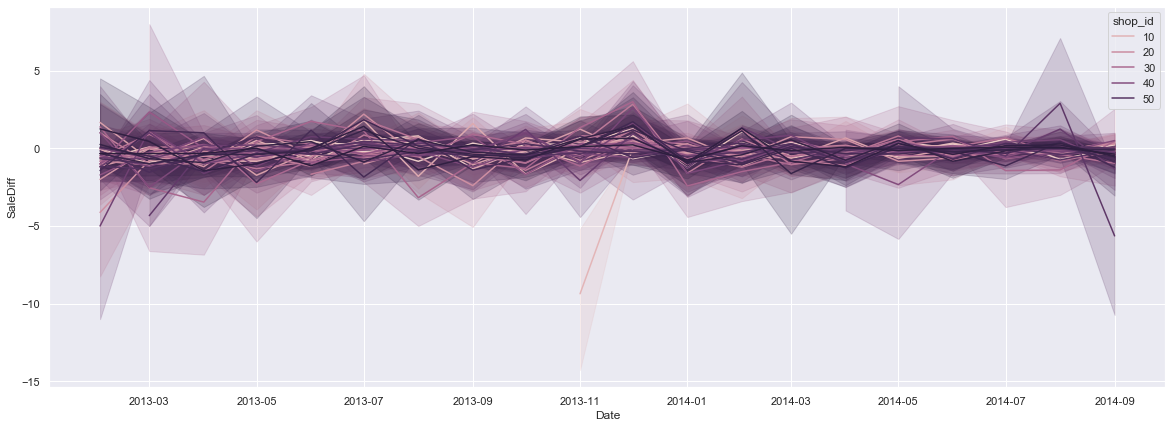

In [75]:
item_id = 65
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7))
sns.lineplot(ax = axs , data=tmp[(tmp.item_category_id == item_id)], x='Date', y= 'SaleDiff', hue = 'shop_id')

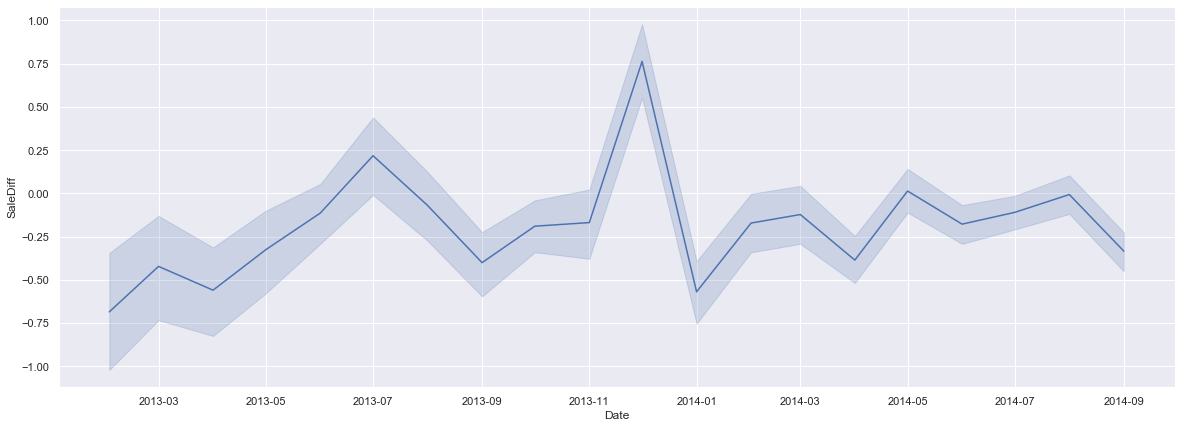

In [76]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7))
sns.lineplot(ax = axs , data=tmp[(tmp.item_category_id == item_id)], x='Date', y= 'SaleDiff')

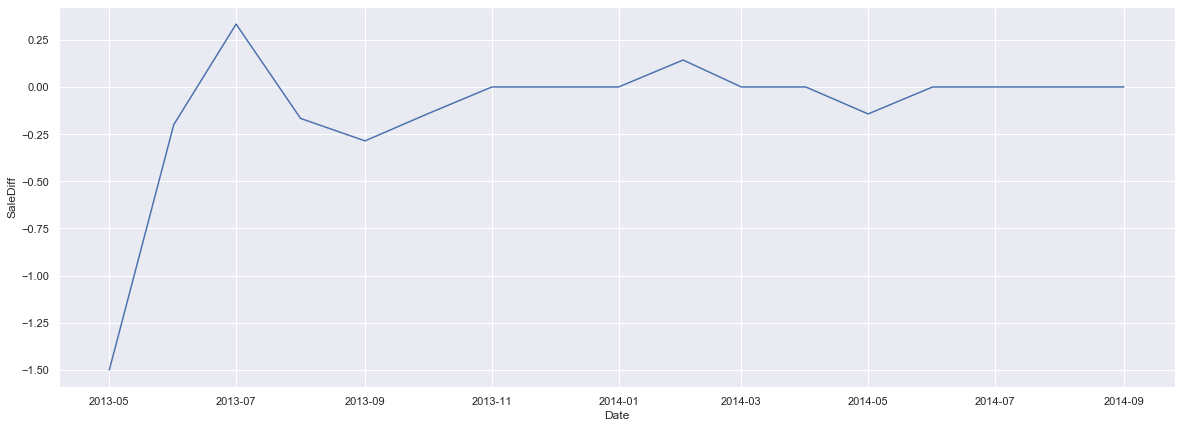

In [77]:
df = tmp[(tmp.item_id == item_id)].groupby(['item_id','Date']).agg(SaleDiff = ('SaleDiff','mean')).reset_index()

fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7))
sns.lineplot(ax = axs , data=df, x='Date', y= 'SaleDiff')

In [78]:
train_full.columns

Index(['item_id', 'shop_id', 'Date', 'Sale', 'item_price', 'Order',
       'item_name', 'item_category_id', 'lenstr', 'NWords', 'ItemWord0',
       'ItemWord_1', 'item_category_name', 'categ_comp1', 'categ_comp2',
       'map_categ_comp1', 'map_categ_comp2', 'shop_name', 'shop_comp1',
       'shop_comp2', 'map_shop_comp1', 'map_shop_comp2', 'shopitem'],
      dtype='object')

In [79]:
train_full.groupby(['map_shop_comp1','map_shop_comp2']).agg(count = ('shop_id', 'nunique')).reset_index().head()

map_shop_comp1  map_shop_comp2  count
0               1               2      1
1               2               3      1
2               3               4      1
3               4               5      1
4               5               0      1

In [80]:
train_full.map_shop_comp1.unique()

array([14, 30, 22,  2,  5,  9, 16, 17, 18, 25, 27, 29, 31, 12, 20, 21, 13,
       11, 26,  3,  7, 10, 23,  1,  8, 19,  4, 28,  6, 24, 15],
      dtype=int64)

In [81]:
train_full.map_shop_comp2.unique()

array([18, 42, 24, 36,  3,  0,  6,  9, 20, 22, 28,  2, 41, 44, 45,  7, 13,
       17, 25, 32, 34, 35, 40,  8, 19, 21, 14, 11, 23,  4, 10, 16, 37, 43,
       33,  5, 12, 39, 30, 31, 38, 27, 26], dtype=int64)

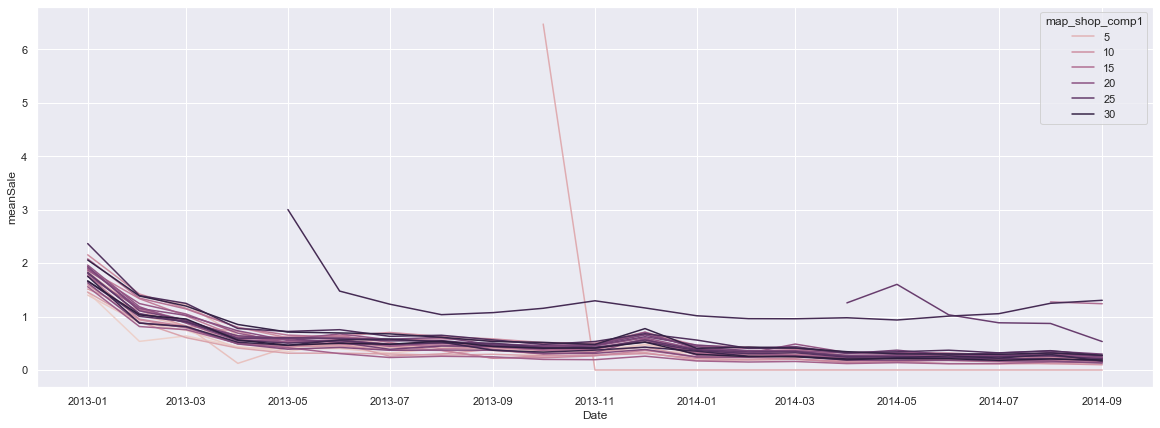

In [82]:
tmp = train_full.groupby(['map_shop_comp1','Date']).agg(meanSale = ('Sale', 'mean')).reset_index()
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7))
sns.lineplot(ax = axs , data=tmp, x='Date', y= 'meanSale', hue = 'map_shop_comp1')

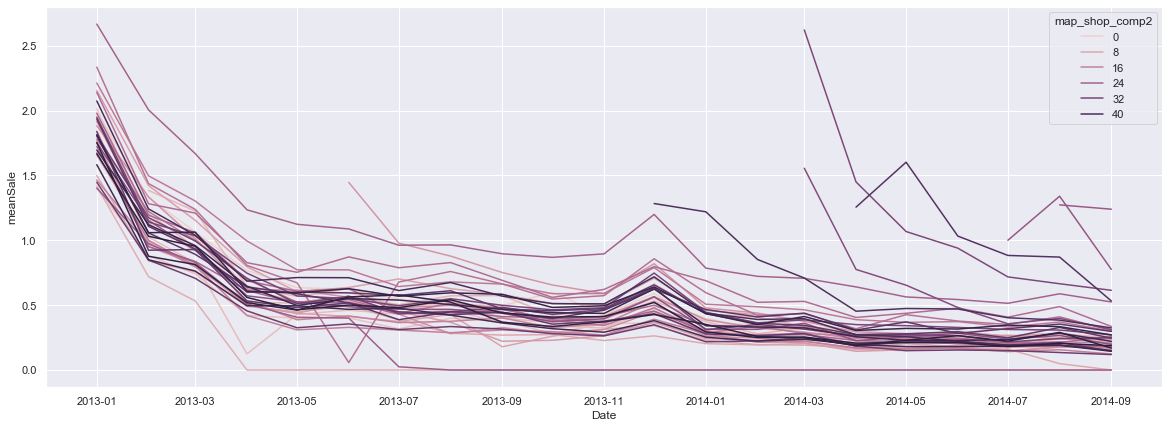

In [83]:
tmp = train_full.groupby(['map_shop_comp2','Date']).agg(meanSale = ('Sale', 'mean')).reset_index()
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7))
sns.lineplot(ax = axs , data=tmp, x='Date', y= 'meanSale', hue = 'map_shop_comp2')

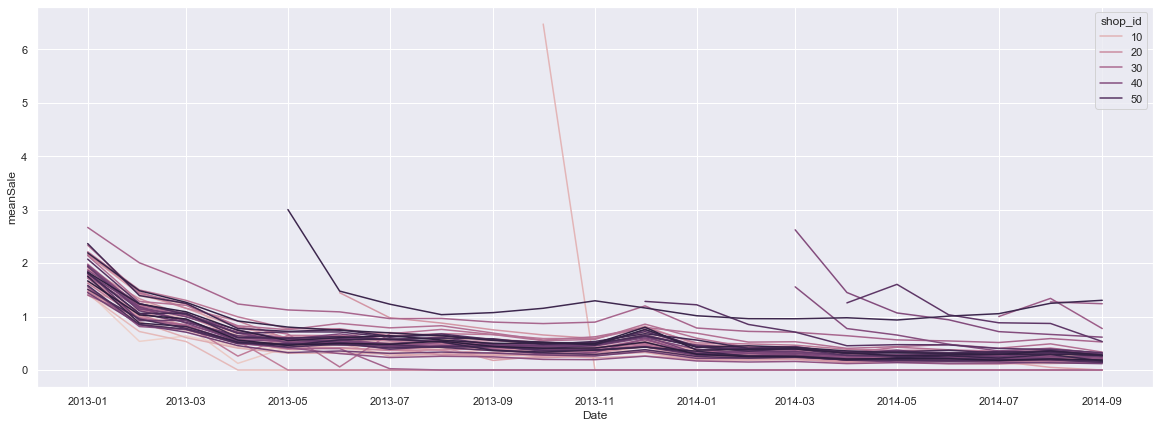

In [84]:
tmp = train_full.groupby(['shop_id','Date']).agg(meanSale = ('Sale', 'mean')).reset_index()
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7))
sns.lineplot(ax = axs , data=tmp, x='Date', y= 'meanSale', hue = 'shop_id')

In [85]:
train_full.columns

Index(['item_id', 'shop_id', 'Date', 'Sale', 'item_price', 'Order',
       'item_name', 'item_category_id', 'lenstr', 'NWords', 'ItemWord0',
       'ItemWord_1', 'item_category_name', 'categ_comp1', 'categ_comp2',
       'map_categ_comp1', 'map_categ_comp2', 'shop_name', 'shop_comp1',
       'shop_comp2', 'map_shop_comp1', 'map_shop_comp2', 'shopitem'],
      dtype='object')

In [86]:
len(train_full.map_shop_comp1.unique()), len(train_full.map_shop_comp2.unique()),

(31, 43)

In [87]:
len(train_full.item_id.unique()), len(train_full.ItemWord0.unique()), len(train_full.ItemWord_1.unique()), 

(15667, 4434, 4200)

In [88]:
len(train_full.item_category_id.unique()), len(train_full.map_categ_comp1.unique()), len(train_full.map_categ_comp2.unique()),

(71, 15, 53)

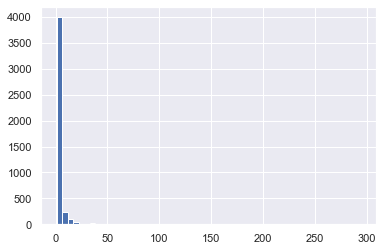

In [89]:
train_full.groupby(['ItemWord0']).agg(Count = ('item_id', 'nunique')).reset_index().sort_values('Count',ascending = False).Count.hist(bins = 55)

In [90]:
tmp = train_full.groupby(['map_shop_comp1','map_categ_comp1','Date']).agg(meanSale = ('Sale', 'mean')).reset_index()
tmp['id'] = tmp['map_shop_comp1'].astype(str) +'-'+  tmp['map_categ_comp1'].astype(str)

ids = tmp.id.unique()
numbs = list(range(0,len(ids)))
maps = dict(zip(ids,numbs))

tmp['id'] = tmp['id'].map(maps)

In [91]:
idsv = list(tmp.id.unique())
ids = np.random.choice(idsv, 50)

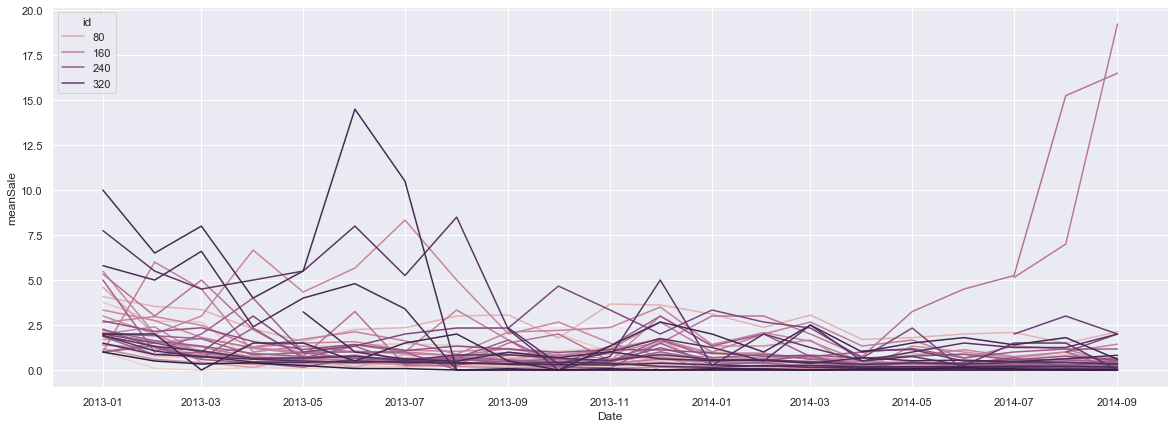

In [92]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7))
sns.lineplot(ax = axs , data=tmp[tmp.id.isin(ids)], x='Date', y= 'meanSale', hue = 'id')

In [93]:
def plot_count_global(index_col, count_var):
    tmp = train_full.groupby([index_col]).agg(count = (count_var, 'nunique')).reset_index().sort_values('count', ascending = False).reset_index(drop= True)
    tmp = tmp.rename(columns = {'count':f'count_{count_var}'})
    tmp[f'id for {index_col}'] = tmp.index

    fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(5,7))
    sns.scatterplot(ax = axs , data=tmp, x=f'count_{count_var}', y = f'id for {index_col}')

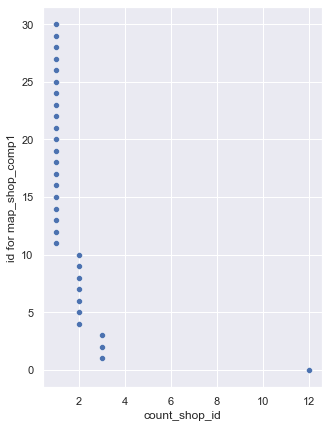

In [94]:
plot_count_global(index_col = 'map_shop_comp1', count_var = 'shop_id')

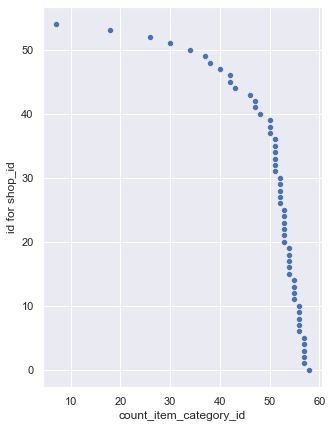

In [95]:
plot_count_global(index_col = 'shop_id', count_var = 'item_category_id')

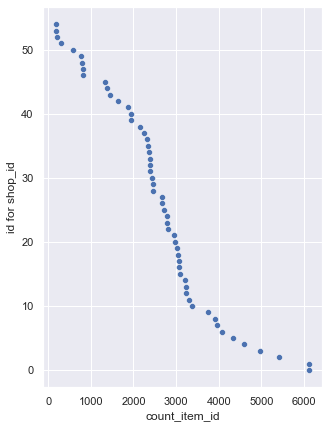

In [96]:
plot_count_global(index_col = 'shop_id', count_var = 'item_id')

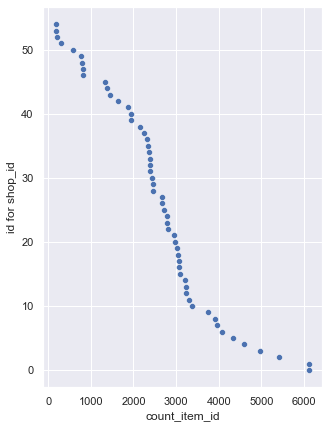

In [97]:
plot_count_global(index_col = 'shop_id', count_var = 'item_id')

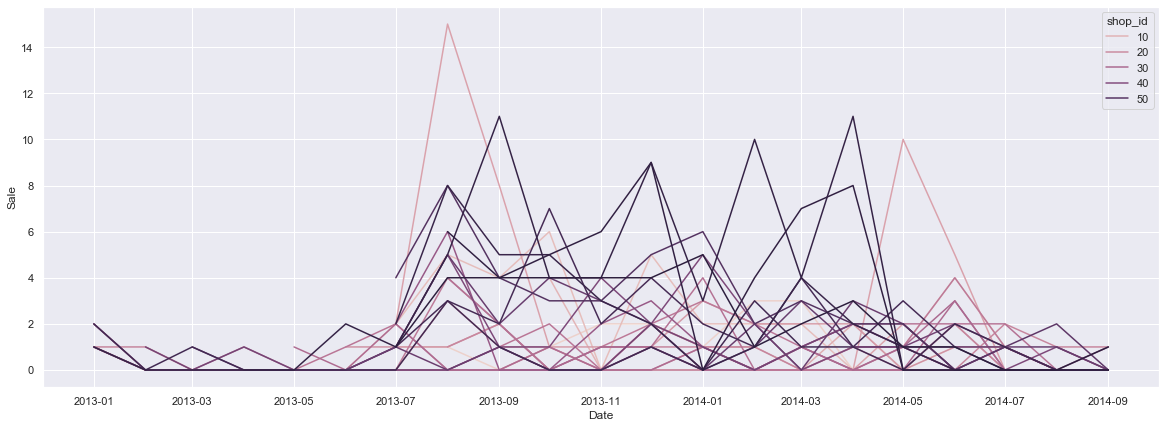

In [98]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7))
sns.lineplot(ax = axs , data=train_full[train_full.item_id.isin([19993])], x='Date', y= 'Sale', hue = 'shop_id')

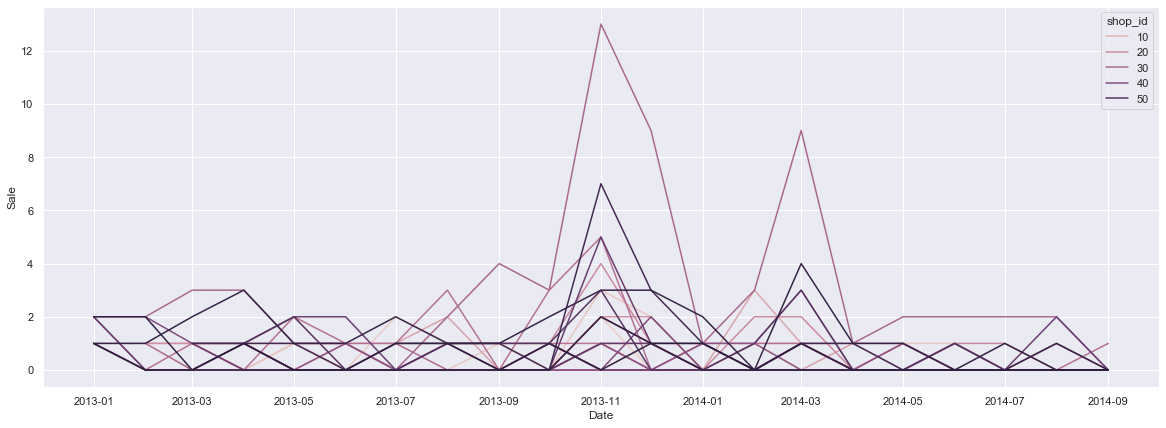

In [99]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7))
sns.lineplot(ax = axs , data=train_full[train_full.item_id.isin([19751])], x='Date', y= 'Sale', hue = 'shop_id')

In [100]:
def plot_count_global_merge(index_col, count_var):
    tmp = train_full.groupby([index_col]).agg(count = (count_var, 'nunique')).reset_index().sort_values('count', ascending = False).reset_index(drop= True)
    tmp = tmp.rename(columns = {'count':f'count_{count_var}'})
    tmp[f'id for {index_col}'] = tmp.index
    
    train1_v2 = train_full[train_full.Sale > 3]
    tmp_2 = train1_v2.groupby([index_col]).agg(count = (count_var, 'nunique')).reset_index().sort_values('count', ascending = False).reset_index(drop= True)
    tmp_2 = tmp_2.rename(columns = {'count':f'count_{count_var}_filter'})
    
    merge = tmp.merge(tmp_2, how = 'left', on = [index_col])

    fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(9,7))
    sns.scatterplot(ax = axs[0] , data=merge, x=f'count_{count_var}', y = f'id for {index_col}')
    sns.scatterplot(ax = axs[1] , data=merge, x=f'count_{count_var}_filter', y = f'id for {index_col}')
    fig.show()

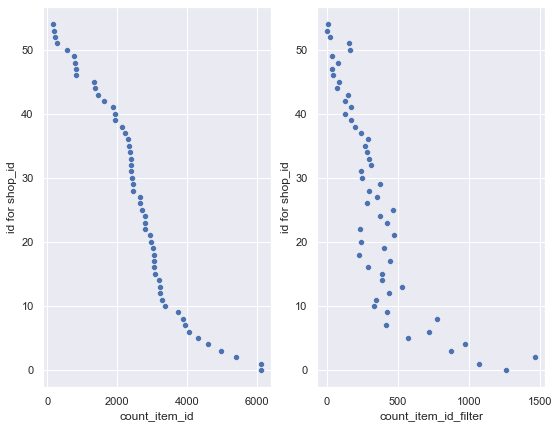

In [101]:
plot_count_global_merge(index_col = 'shop_id', count_var = 'item_id')

In [102]:
train_full.columns

Index(['item_id', 'shop_id', 'Date', 'Sale', 'item_price', 'Order',
       'item_name', 'item_category_id', 'lenstr', 'NWords', 'ItemWord0',
       'ItemWord_1', 'item_category_name', 'categ_comp1', 'categ_comp2',
       'map_categ_comp1', 'map_categ_comp2', 'shop_name', 'shop_comp1',
       'shop_comp2', 'map_shop_comp1', 'map_shop_comp2', 'shopitem'],
      dtype='object')

In [103]:
train_full.groupby(['shop_id']).agg(count = ('item_category_id', 'nunique')).sort_values('count',ascending = False).head()

count
shop_id       
6           58
31          57
54          57
37          57
56          57

In [104]:
train_full[train_full.shop_id == 37].groupby(['item_category_id']).agg(count = ('item_id', 'nunique')).sort_values('count',ascending = False).head()

count
item_category_id       
40                  720
55                  555
37                  368
30                  139
19                  130

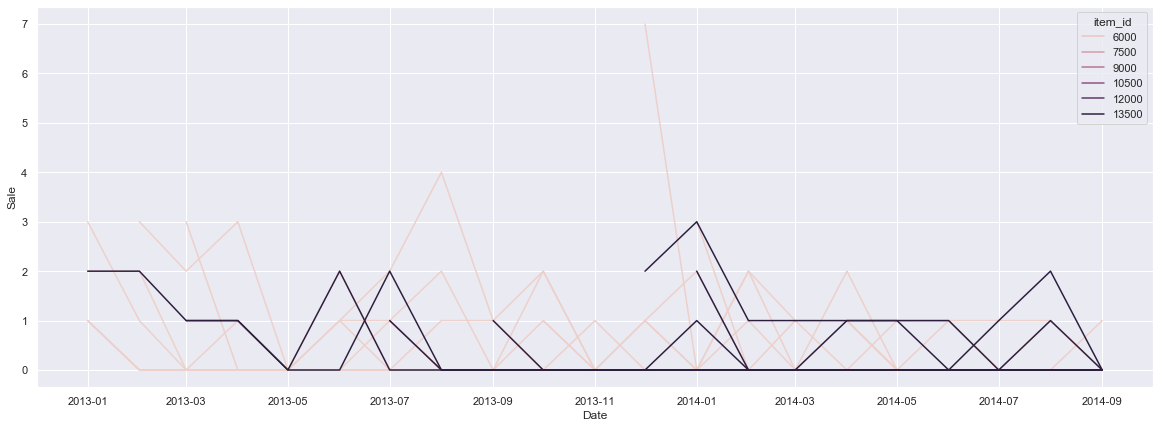

In [105]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7))
sns.lineplot(ax = axs , data=train_full[(train_full.shop_id == 2) & (train_full.item_category_id == 2)], x='Date', y= 'Sale', hue = 'item_id')

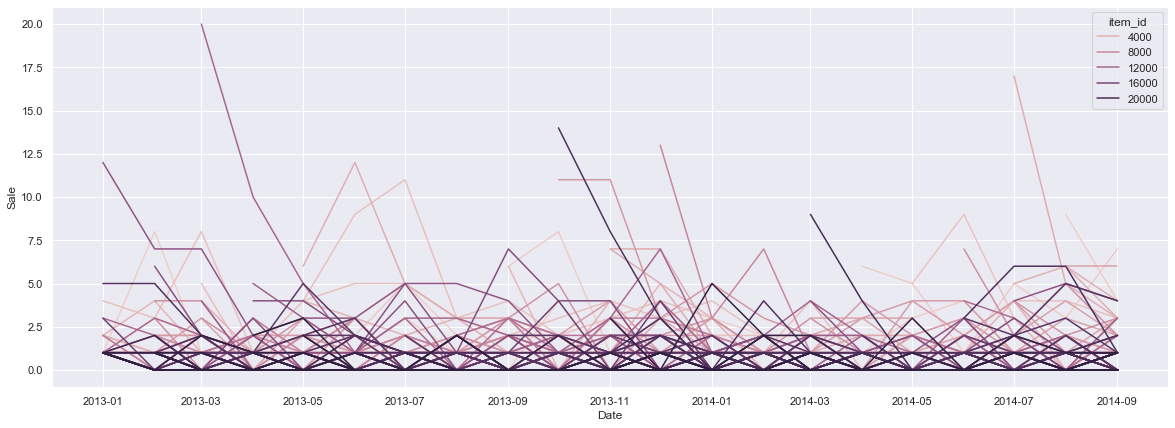

In [106]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7))
sns.lineplot(ax = axs , data=train_full[(train_full.shop_id == 6) & (train_full.item_category_id == 55)], x='Date', y= 'Sale', hue = 'item_id')

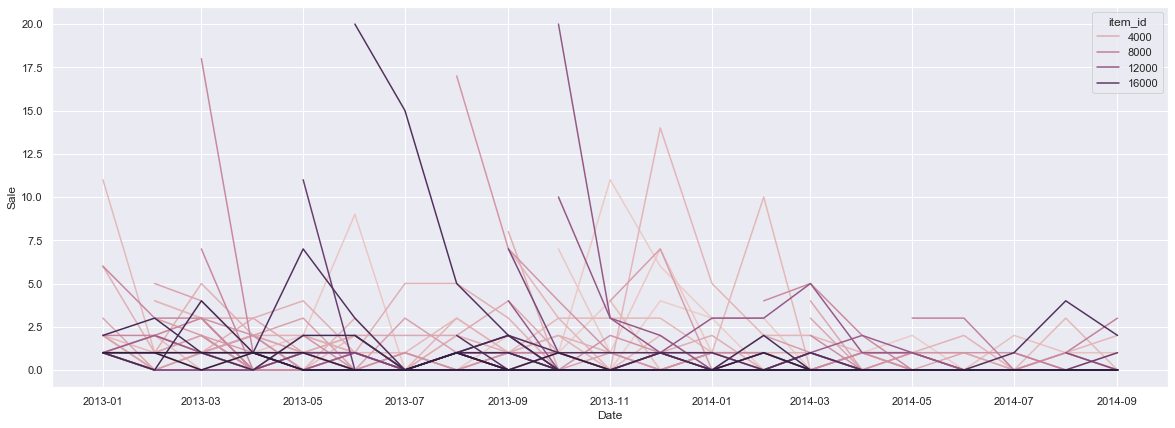

In [107]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7))
sns.lineplot(ax = axs , data=train_full[(train_full.shop_id == 37) & (train_full.item_category_id == 19)], x='Date', y= 'Sale', hue = 'item_id')

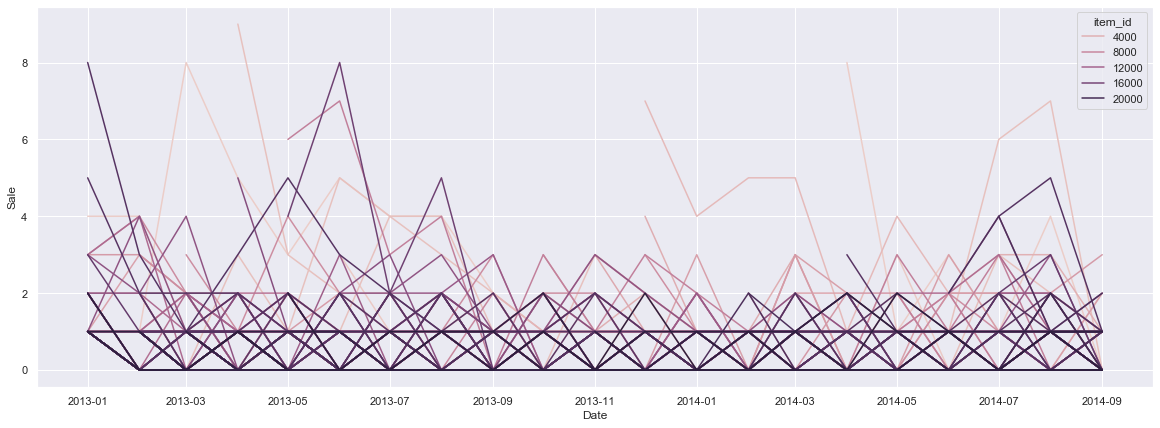

In [108]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7))
sns.lineplot(ax = axs , data=train_full[(train_full.shop_id == 37) & (train_full.item_category_id == 55)], x='Date', y= 'Sale', hue = 'item_id')

In [109]:
train_full.groupby(['item_name','ItemWord0','ItemWord_1','item_category_name','categ_comp1','categ_comp2','shop_name','shop_comp1','shop_comp2']).agg(count = ('Sale','count')).reset_index()

item_name  ItemWord0  \
0           ***В ЛУЧАХ СЛАВЫ   (UNV)                    D          3   
1         ***ГОЛУБАЯ ВОЛНА  (Univ)                      D          4   
2                ***УДАР ПО ВОРОТАМ (UNI)               D          7   
3                ***ЧАЙ С МУССОЛИНИ                     D          8   
4           ***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI)             D          9   
...                                                   ...        ...   
126011  Язык запросов 1С:Предприятия 8 (+CD). Хрустале...       5251   
126012                                Яйцо для Little Inu       5252   
126013                                Яйцо для Little Inu       5252   
126014                                Яйцо для Little Inu       5252   
126015                                Яйцо для Little Inu       5252   

        ItemWord_1                 item_category_name categ_comp1  \
0             1439                         Кино - DVD        Кино   
1             1439                         Кино - DVD        Кино   
2             1439                         Кино - DVD        Кино   
3             1439                         Кино - DVD        Кино   
4             1439                         Кино - DVD        Кино   
...            ...                                ...         ...   
126011        2957  Книги - Методические материалы 1С       Книги   
126012        1697   Подарки - Гаджеты, роботы, спорт     Подарки   
126013        1697   Подарки - Гаджеты, роботы, спорт     Подарки   
126014        1697   Подарки - Гаджеты, роботы, спорт     Подарки   
126015        1697   Подарки - Гаджеты, роботы, спорт     Подарки   

                      categ_comp2               shop_name shop_comp1  \
0                             DVD         Химки ТЦ "Мега"      Химки   
1                             DVD         Химки ТЦ "Мега"      Химки   
2                             DVD         Химки ТЦ "Мега"      Химки   
3                             DVD         Химки ТЦ "Мега"      Химки   
4                             DVD         Химки ТЦ "Мега"      Химки   
...                           ...                     ...        ...   
126011  Методические материалы 1С      Тюмень ТЦ "Гудвин"     Тюмень   
126012     Гаджеты, роботы, спорт        Адыгея ТЦ "Мега"     Адыгея   
126013     Гаджеты, роботы, спорт        Коломна ТЦ "Рио"    Коломна   
126014     Гаджеты, роботы, спорт  СПб ТК "Невский Центр"        СПб   
126015     Гаджеты, роботы, спорт         СПб ТК "Сенная"        СПб   

           shop_comp2  count  
0                Мега      2  
1                Мега      3  
2                Мега      3  
3                Мега      2  
4                Мега      2  
...               ...    ...  
126011         Гудвин      1  
126012           Мега     21  
126013            Рио     20  
126014  Невский Центр     20  
126015         Сенная     19  

[126016 rows x 10 columns]

In [110]:
train_full.groupby(['shop_comp1','shop_comp2']).agg(count = ('Sale','count')).reset_index().head()

shop_comp1       shop_comp2  count
0     Адыгея             Мега  19492
1   Балашиха  Октябрь-Киномир  22004
2   Волжский       Волга Молл  34854
3    Вологда         Мармелад  26925
4    Воронеж             Град  16484

In [111]:
train_full.columns

Index(['item_id', 'shop_id', 'Date', 'Sale', 'item_price', 'Order',
       'item_name', 'item_category_id', 'lenstr', 'NWords', 'ItemWord0',
       'ItemWord_1', 'item_category_name', 'categ_comp1', 'categ_comp2',
       'map_categ_comp1', 'map_categ_comp2', 'shop_name', 'shop_comp1',
       'shop_comp2', 'map_shop_comp1', 'map_shop_comp2', 'shopitem'],
      dtype='object')

In [112]:
tmp = train_full[train_full.item_price > 0].groupby(['shop_id','item_category_id','Date']).agg( med = ('item_price','median')).reset_index()

In [113]:
tmp.head()

shop_id  item_category_id       Date     med
0        2                 2 2013-01-01  2344.0
1        2                 2 2013-02-01  1669.5
2        2                 2 2013-03-01  3344.5
3        2                 2 2013-04-01  2694.5
4        2                 2 2013-06-01  2390.0

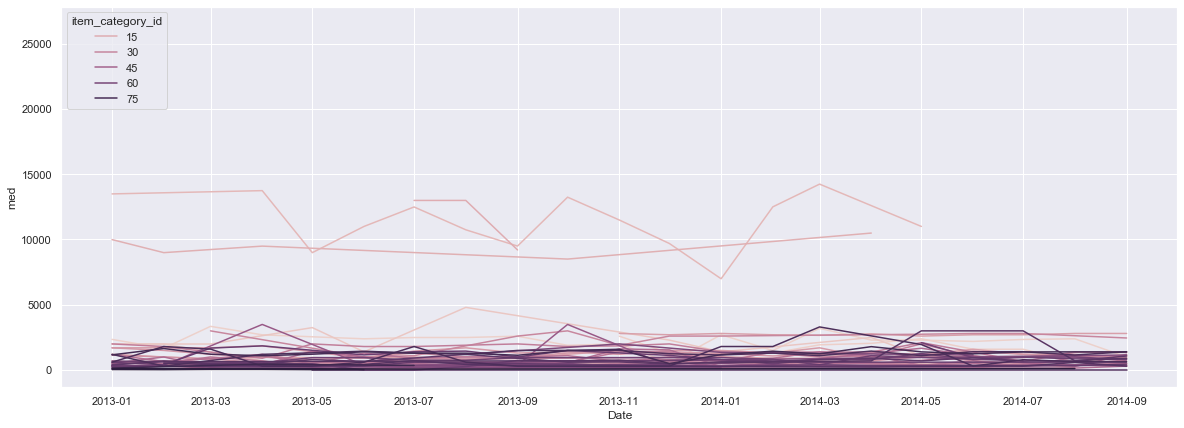

In [114]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7))
sns.lineplot(ax = axs , data=tmp[tmp.shop_id == 2], x='Date', y= 'med', hue = 'item_category_id')

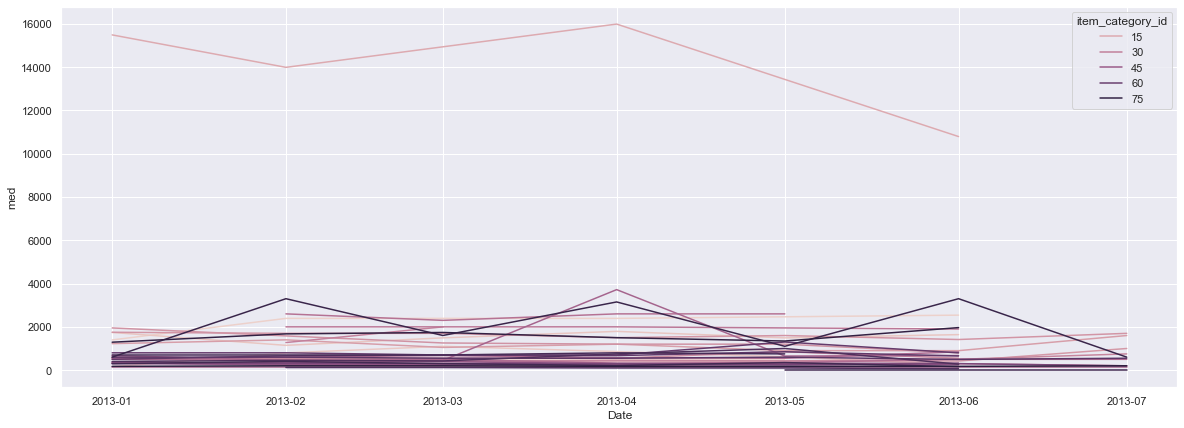

In [115]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,7))
sns.lineplot(ax = axs , data=tmp[tmp.shop_id == 32], x='Date', y= 'med', hue = 'item_category_id')

In [116]:
tmp = train_full

In [117]:
tmp['mean_item_category_id'] = tmp[tmp.item_price > 0].groupby(['shop_id','item_category_id','Date']).item_price.transform('median')

In [118]:
tmp

item_id  shop_id       Date  Sale  item_price  Order  \
0             19       25 2013-01-01   1.0        28.0      1   
7             27       58 2013-01-01   1.0      1890.0      1   
9             28       31 2013-01-01   3.0       549.0      1   
11            28       46 2013-01-01   1.0       549.0      1   
14            29       31 2013-01-01   2.0      2499.0      1   
...          ...      ...        ...   ...         ...    ...   
4795911    22168        2 2014-09-01   0.0         0.0     21   
4795912    22168       12 2014-09-01   0.0         0.0     21   
4795913    22168       16 2014-09-01   0.0         0.0     21   
4795914    22168       42 2014-09-01   0.0         0.0     21   
4795915    22168       43 2014-09-01   0.0         0.0     21   

                                       item_name  item_category_id  lenstr  \
0                      /ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72                40      25   
7              007 Legends [PS3, русская версия]                19      33   
9        007 Legends [PС, Jewel, русская версия]                30      39   
11       007 Legends [PС, Jewel, русская версия]                30      39   
14        007 Legends [Xbox 360, русская версия]                23      38   
...                                          ...               ...     ...   
4795911                      Яйцо для Little Inu                62      19   
4795912                      Яйцо для Little Inu                62      19   
4795913                      Яйцо для Little Inu                62      19   
4795914                      Яйцо для Little Inu                62      19   
4795915                      Яйцо для Little Inu                62      19   

         NWords  ...             categ_comp2  map_categ_comp1 map_categ_comp2  \
0             3  ...                     DVD               11              22   
7             5  ...                     PS3                5               2   
9             6  ...     Стандартные издания                8              14   
11            6  ...     Стандартные издания                8              14   
14            6  ...                XBOX 360                5               6   
...         ...  ...                     ...              ...             ...   
4795911       4  ...  Гаджеты, роботы, спорт               14              43   
4795912       4  ...  Гаджеты, роботы, спорт               14              43   
4795913       4  ...  Гаджеты, роботы, спорт               14              43   
4795914       4  ...  Гаджеты, роботы, спорт               14              43   
4795915       4  ...  Гаджеты, роботы, спорт               14              43   

                       shop_name        shop_comp1     shop_comp2  \
0            Москва ТРК "Атриум"            Москва         Атриум   
7        Якутск ТЦ "Центральный"            Якутск    Центральный   
9        Москва ТЦ "Семеновский"            Москва    Семеновский   
11         Сергиев Посад ТЦ "7Я"           Сергиев             7Я   
14       Москва ТЦ "Семеновский"            Москва    Семеновский   
...                          ...               ...            ...   
4795911         Адыгея ТЦ "Мега"            Адыгея           Мега   
4795912      Интернет-магазин ЧС  Интернет-магазин           None   
4795913         Коломна ТЦ "Рио"           Коломна            Рио   
4795914   СПб ТК "Невский Центр"               СПб  Невский Центр   
4795915          СПб ТК "Сенная"               СПб         Сенная   

         map_shop_comp1 map_shop_comp2  shopitem mean_item_category_id  
0                    14             18     25_19                 149.0  
7                    30             42     58_27                1167.5  
9                    14             24     31_28                 299.0  
11                   22             36     46_28                 349.0  
14                   14             24     31_29                1699.0  
...                 ...            ...       ...   

In [119]:
train_full.groupby(['categ_comp1','map_shop_comp2'])

In [120]:
train_go = train_full.assign(SaleBin = np.where(train_full.Sale > 0 ,1 , 0))
train_go = train_go[['item_id','shop_id','item_category_id','map_categ_comp1','map_categ_comp2','map_shop_comp1','map_shop_comp2','Date', 'SaleBin']]

In [121]:
def countings(data, groupby_columns, name_feature):
    df_count_global = data.groupby(groupby_columns).agg(counts = ('SaleBin','sum')).reset_index()
    df_count_global = df_count_global.rename(columns = {'counts', f'global_{name_feature}'})
    
    return df_count_global
    
def window_countings(data, groupby_columns, name_feature, window = '90D'):
    
    
    df_feature = data.groupby(groupby_columns + ['Date']).agg(counts = ('SaleBin','sum')).reset_index()
    roll_calc = df_feature.groupby(groupby_columns).rolling('90D', on="Date")["counts"].mean()
    tmp = tmp.set_index(['item_id','Date'])
    
    df_count_global = df_count_global.rename(columns = {'counts', f'global_{name_feature}'})
    
    return df_count_global

In [122]:
train_go.columns

Index(['item_id', 'shop_id', 'item_category_id', 'map_categ_comp1',
       'map_categ_comp2', 'map_shop_comp1', 'map_shop_comp2', 'Date',
       'SaleBin'],
      dtype='object')

In [123]:
train_go.head()

item_id  shop_id  item_category_id  map_categ_comp1  map_categ_comp2  \
0        19       25                40               11               22   
7        27       58                19                5                2   
9        28       31                30                8               14   
11       28       46                30                8               14   
14       29       31                23                5                6   

    map_shop_comp1  map_shop_comp2       Date  SaleBin  
0               14              18 2013-01-01        1  
7               30              42 2013-01-01        1  
9               14              24 2013-01-01        1  
11              22              36 2013-01-01        1  
14              14              24 2013-01-01        1

In [130]:
train_go['globalcount_shops_in_item_category_id'] = train_go.groupby('map_categ_comp1').shop_id.transform('nunique')
train_go['globalcount_shops_in_item_id'] = train_go.groupby('item_id').shop_id.transform('nunique')
train_go['globalcount_items_in_shop_id'] = train_go.groupby('shop_id').item_id.transform('nunique')
train_go['globalcount_categos_in_shop_id'] = train_go.groupby('item_category_id').item_id.transform('nunique')

In [132]:
tf = train_go[['globalcount_shops_in_item_category_id','globalcount_shops_in_item_id', 'globalcount_items_in_shop_id','globalcount_categos_in_shop_id','SaleBin']].sample(frac = 0.1)

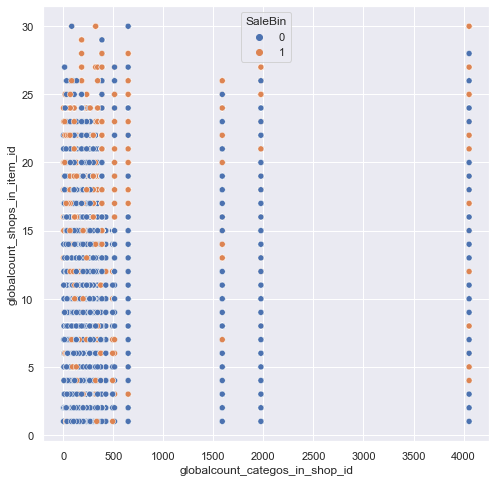

In [133]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

sns.scatterplot(ax = axs , data=tf, x='globalcount_categos_in_shop_id', y = 'globalcount_shops_in_item_id', hue = 'SaleBin')